In [3]:
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

# Recreating windfield risk analysis

In this lesson, we are replicating the windfield risk analysis presented by Chad Council in his lecture. We will be using two main data sets:
- The wind field for the [1938 new england hurricane](https://en.wikipedia.org/wiki/1938_New_England_hurricane)
- The [CDC Social Vulnerability Index (SVI) for 2018](https://svi.cdc.gov/data-and-tools-download.html)
This analysis will see which areas are at highest risk due to wind damage if the 1938 hurricane hit today

In [4]:
# unzip windfield into a folder called windfield
!unzip WindField.zip -d windfield

Archive:  WindField.zip
replace windfield/WindField.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<Axes: >

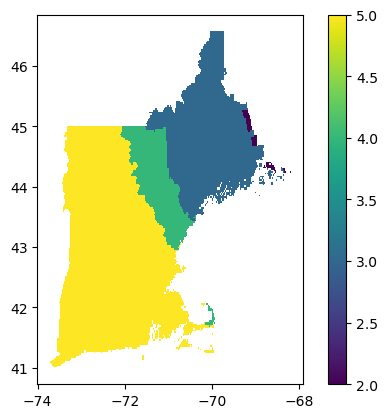

In [5]:
# load windfield into gpd geodataframe, plot the gridcode (wind speed rating: higher is more dangerous)
windfield_df = gpd.read_file('windfield/WindField.shp')
windfield_df.plot('GRIDCODE', legend=True)

The social vulnerability index data is hosted on our file server.
The documentation for the dataset has been included in this repository in `SVI2018Documentation.pdf` for ease of reference. It documents each column, and the data sources that were used to compute the respective entry.

In [16]:
!wget https://files.bwsi-remote-sensing.net/data/SVI2020_US_tract.gdb.zip

--2023-07-17 13:55:33--  https://files.bwsi-remote-sensing.net/data/SVI2020_US_tract.gdb.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 35.164.4.113, 54.191.213.207, 54.203.54.46, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|35.164.4.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64955310 (62M) [application/zip]
Saving to: ‘SVI2020_US_tract.gdb.zip’

SVI2020_US_tract.gd 100%[===================>]  61.95M   223MB/s    in 0.3s    

2023-07-17 13:55:34 (223 MB/s) - ‘SVI2020_US_tract.gdb.zip’ saved [64955310/64955310]



In [17]:
# load SVI2018 from course shared folder
svi_df = gpd.read_file('SVI2020_US_tract.gdb.zip')
svi_df

KeyboardInterrupt: 

The overall vulnerability score is given in the column `RPL_THEMES`. Values of `-999` indicate missing data. Higher values (closer to 1) are higher vulnerability. Lower values (closer to 0) are less vulnerable.

In [18]:
svi_df['RPL_THEMES']

0       -999.0000
1       -999.0000
2       -999.0000
3       -999.0000
4       -999.0000
           ...   
72832      0.7090
72833      0.9173
72834      0.9723
72835      0.7378
72836      0.9831
Name: RPL_THEMES, Length: 72837, dtype: float64

In [25]:
# replace missing data with None values
svi_df['RPL_THEMES'] = svi_df['RPL_THEMES'].replace({-999:np.nan})

(-180.0, -60.0)

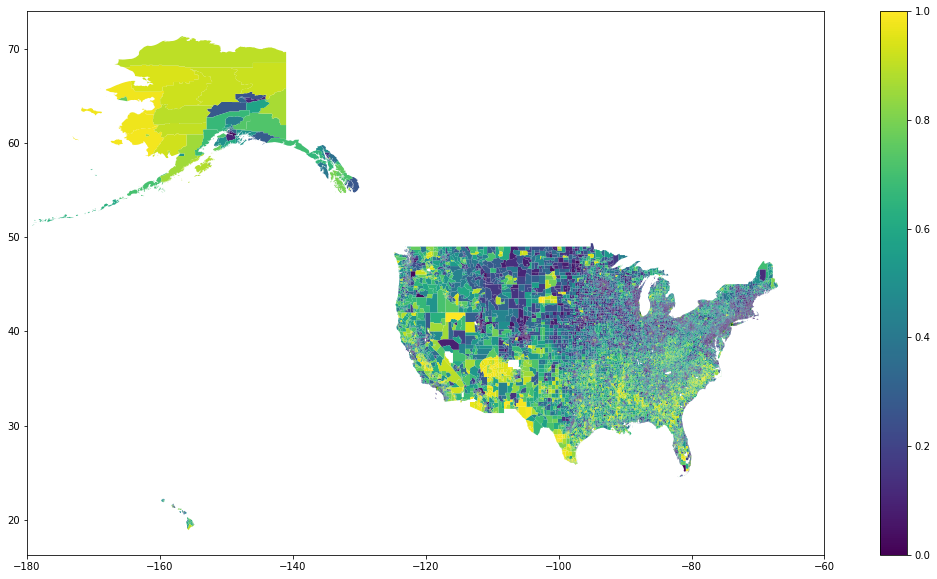

In [32]:
# take a look at overall SVI (takes a minute to run because it's the whole country)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
svi_df.dropna(subset=['RPL_THEMES']).plot('RPL_THEMES', legend=True, ax=ax)
ax.set_xlim([-180,-60])

To combine the two data sets, we will use a powerful function called a "spatial join". Recall the database joins from lesson 1: they merge dataframes based on shared values in a column.

For geodataframes, we can do something similar using the geometry column: we can merge dataframe rows based on how their respective geometries interact with one another.

The function we use to do this is [`gpd.sjoin()`](https://geopandas.org/reference/geopandas.sjoin.html). Let's take a look at the function

In [23]:
gpd.sjoin?

Signature:
gpd.sjoin(
    left_df,
    right_df,
    how='inner',
    op='intersects',
    lsuffix='left',
    rsuffix='right',
)
Docstring:
Spatial join of two GeoDataFrames.

Parameters
----------
left_df, right_df : GeoDataFrames
how : string, default 'inner'
    The type of join:

    * 'left': use keys from left_df; retain only left_df geometry column
    * 'right': use keys from right_df; retain only right_df geometry column
    * 'inner': use intersection of keys from both dfs; retain only
      left_df geometry column
op : string, default 'intersects'
    Binary predicate, one of {'intersects', 'contains', 'within'}.
    See http://shapely.readthedocs.io/en/latest/manual.html#binary-predicates.
lsuffix : string, default 'left'
    Suffix to apply to overlapping column names (left GeoDataFrame).
rsuffix : string, default 'right'
    Suffix to apply to overlapping column names (right GeoDataFrame).
File:      /opt/conda/lib/python3.7/site-packages/geopandas/tools/sjoin.py
Type:  

There are three important sets of arguments for the function:
- left and right geodataframes
- 'how': what kind of join: left, right, or inner
- 'op': what kind of spatial interaction between the geometries

In [37]:
joined_df = gpd.sjoin(svi_df, windfield_df, how='inner', op='intersects')
joined_df

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_STAr,Shape_STLe,geometry,index_right,OBJECTID,ID,GRIDCODE
94,09,CONNECTICUT,CT,09003,Hartford,09003980000,"Census Tract 9800, Hartford County, Connecticut",2.515873,0,12,...,-999.0,-999.0,2066,0.000705,0.138085,"POLYGON ((-72.70655 41.93651, -72.70417 41.935...",68,69.0,69.0,5.0
96,09,CONNECTICUT,CT,09013,Tolland,09013538100,"Census Tract 5381, Tolland County, Connecticut",0.621442,1841,146,...,-999.0,-999.0,2428,0.000175,0.062746,"POLYGON ((-72.50864 42.03114, -72.50498 42.025...",68,69.0,69.0,5.0
245,25,MASSACHUSETTS,MA,25001,Barnstable,25001990000,"Census Tract 9900, Barnstable County, Massachu...",0.000000,0,12,...,-999.0,-999.0,0,0.000019,0.032253,"MULTIPOLYGON (((-70.62682 41.65970, -70.62201 ...",68,69.0,69.0,5.0
246,25,MASSACHUSETTS,MA,25005,Bristol,25005990000,"Census Tract 9900, Bristol County, Massachusetts",0.000000,0,12,...,-999.0,-999.0,0,0.000012,0.015037,"POLYGON ((-70.94865 41.58406, -70.94658 41.584...",68,69.0,69.0,5.0
248,25,MASSACHUSETTS,MA,25015,Hampshire,25015820802,"Census Tract 8208.02, Hampshire County, Massac...",0.272713,1190,232,...,1.8,1.9,2101,0.000077,0.037501,"POLYGON ((-72.53641 42.32625, -72.53526 42.328...",68,69.0,69.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36582,44,RHODE ISLAND,RI,44005,Newport,44005041300,"Census Tract 413, Newport County, Rhode Island",9.447682,5496,18,...,3.4,3.4,3274,0.002741,0.435504,"MULTIPOLYGON (((-71.40056 41.46094, -71.39906 ...",55,56.0,56.0,5.0
36583,44,RHODE ISLAND,RI,44005,Newport,44005041400,"Census Tract 414, Newport County, Rhode Island",20.546136,3505,15,...,3.5,2.7,1710,0.006314,0.365650,"POLYGON ((-71.21223 41.54535, -71.19674 41.548...",59,60.0,60.0,5.0
36688,44,RHODE ISLAND,RI,44009,Washington,44009041500,"Census Tract 415, Washington County, Rhode Island",9.081643,827,150,...,8.7,5.4,747,0.002958,0.276325,"POLYGON ((-71.61313 41.16028, -71.61053 41.162...",67,68.0,68.0,5.0
55500,25,MASSACHUSETTS,MA,25019,Nantucket,25019950500,"Census Tract 9505, Nantucket County, Massachus...",23.525614,1116,228,...,0.0,3.2,779,0.008854,0.506087,"POLYGON ((-70.09469 41.29766, -70.09252 41.297...",62,63.0,63.0,5.0


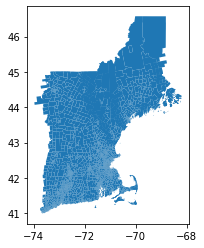

In [34]:
# we can see the shape of the joined dataframe: it only includes the intersection of the two datasets
# at a census-tract level
joined_df.plot()

To compute the wind-vulnerability score, we just multiply the respective columns:


In [38]:
joined_df['wind_vulnerability'] = joined_df['RPL_THEMES'] * joined_df['GRIDCODE']

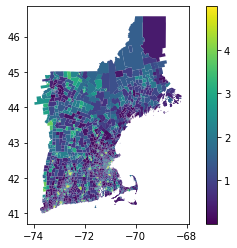

In [39]:
joined_df.plot('wind_vulnerability', legend=True)